# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


In [3]:
data_splits = ["train", "valid", "test", "complete"]
data_dict = load_data(data_splits, dataset="L1000")

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
# Prepare data for training

meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(94440, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.115210,0.83776,-0.80023,-0.25787,-0.621180,-0.53313,-0.260430,...,-0.458550,0.51684,2.86550,-0.152210,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.337130,-0.47045,-0.44483,0.38475,-0.566390,0.27726,0.000645,...,0.008161,-0.33238,-0.20174,-0.605390,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
2,-0.75812,-0.283820,0.594330,0.089136,-0.85230,-0.78754,0.20291,0.018564,-0.22745,-0.839810,...,0.289560,0.16598,0.54440,-0.053607,0.439350,0.42920,-0.37040,-0.51931,-0.21799,-1.29360


In [8]:
print(valid_features_df.shape)
valid_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.534400,0.552700,0.000000,-0.95760,-0.3264,-0.25560,0.00000,0.00000,1.88250,1.86290,...,5.22050,-0.96970,-1.133800,-1.079700,-2.29810,0.8493,0.29560,0.84640,0.19020,-0.47540
1,-0.029159,0.039928,0.045024,0.26740,-1.0234,0.58926,0.57561,0.60793,0.33281,-0.65153,...,-0.25789,0.46169,0.022211,-0.035998,0.67575,2.2909,0.24359,-0.14676,-0.84884,-0.16919
2,0.365290,-1.311300,-0.153500,0.72378,-1.1094,-0.38681,1.05910,0.12169,-1.01300,0.83094,...,-0.22982,-0.21314,-0.088198,0.527700,0.49855,-1.3877,1.00980,-0.21835,0.16329,-0.79029


In [9]:
print(test_features_df.shape)
test_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.28158,1.6038,-1.58650,-0.41677,-2.34260,3.12320,-0.10233,1.62600,0.115840,-0.000233,...,-0.49069,-1.14930,-0.16539,0.49864,1.077800,1.66230,-1.66900,-0.49738,0.51629,1.08940
1,0.77369,1.0853,0.75758,1.04900,1.18270,0.69324,-0.43503,-0.88949,-0.075833,0.208990,...,0.10747,0.97814,0.85407,0.10528,-0.370430,0.89069,-0.26969,-0.98646,-1.07350,0.48240
2,0.63079,1.9072,-1.65190,0.26266,0.68423,-0.38400,1.63160,0.78741,0.732920,-2.431700,...,-1.83770,-0.56064,0.93692,0.96585,-0.036786,1.35430,2.15870,-0.28158,0.53111,-0.46053


In [10]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,4.26410,0.057249,-2.13930,-0.22178,-0.37656,1.91380,0.065576,-0.86895,-0.10227,0.00000,...,5.246200,0.057058,-1.25620,-0.025255,0.168860,-1.639100,0.68510,-0.41942,1.71610,-0.47234
1,-0.38221,0.304310,-0.99592,-0.67083,-0.64824,0.62161,0.889530,0.20376,0.19481,-0.45637,...,0.206690,-0.010866,-0.87206,-0.223750,0.074144,0.093595,0.32667,1.04810,-0.50518,-0.61832
2,-0.57171,-0.755000,-0.71011,0.42889,0.27261,0.31436,-1.545800,0.64195,-0.87685,0.00000,...,-0.005612,1.194500,0.17111,0.334370,-1.089300,-0.114640,0.30483,-0.24947,-0.42835,1.58500


In [11]:

encoder_architecture = [500]
decoder_architecture = [500]


In [12]:

L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=180,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)

L1000_vae.compile_vae()
#1495

In [13]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/180
185/185 [==============================] - 7s 28ms/step - loss: 1625.6355 - recon: 1440.1656 - kl: 24.9737 - val_loss: 1317.5148 - val_recon: 1285.0157 - val_kl: 32.4991
Epoch 2/180
185/185 [==============================] - 4s 23ms/step - loss: 1290.1108 - recon: 1234.3873 - kl: 32.8404 - val_loss: 1230.3132 - val_recon: 1193.2246 - val_kl: 37.0889
Epoch 3/180
185/185 [==============================] - 4s 23ms/step - loss: 1221.4326 - recon: 1169.8313 - kl: 38.9539 - val_loss: 1189.0228 - val_recon: 1146.6775 - val_kl: 42.3456
Epoch 4/180
185/185 [==============================] - 4s 23ms/step - loss: 1176.6476 - recon: 1131.5576 - kl: 43.9308 - val_loss: 1162.8507 - val_recon: 1116.5055 - val_kl: 46.3452
Epoch 5/180
185/185 [==============================] - 4s 23ms/step - loss: 1154.0788 - recon: 1104.1621 - kl: 48.0483 - val_loss: 1149.5701 - val_recon: 1098.3766 - val_kl: 51.1935
Epoch 6/180
185/185 [==============================] - 4s 23ms/step - loss: 1132.5468 - re

Epoch 92/180
185/185 [==============================] - 4s 23ms/step - loss: 903.4987 - recon: 821.7150 - kl: 82.7776 - val_loss: 926.0770 - val_recon: 843.5319 - val_kl: 82.5452
Epoch 93/180
185/185 [==============================] - 4s 23ms/step - loss: 902.2050 - recon: 821.5444 - kl: 82.8030 - val_loss: 924.9482 - val_recon: 842.4606 - val_kl: 82.4876
Epoch 94/180
185/185 [==============================] - 4s 23ms/step - loss: 904.5073 - recon: 821.0941 - kl: 82.7865 - val_loss: 925.8762 - val_recon: 843.3408 - val_kl: 82.5354
Epoch 95/180
185/185 [==============================] - 4s 23ms/step - loss: 899.1061 - recon: 819.9201 - kl: 82.7885 - val_loss: 926.4774 - val_recon: 843.5929 - val_kl: 82.8843
Epoch 96/180
185/185 [==============================] - 4s 23ms/step - loss: 903.0333 - recon: 820.8995 - kl: 82.8667 - val_loss: 925.8901 - val_recon: 843.2972 - val_kl: 82.5927
Epoch 97/180
185/185 [==============================] - 4s 23ms/step - loss: 901.8439 - recon: 820.0621 -

In [14]:
    L1000_vae.vae

In [15]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df
#1067 for level 1

,loss,recon,kl,val_loss,val_recon,val_kl
0,1465.139526,1440.165649,24.973726,1317.514771,1285.015747,32.499146
1,1267.227051,1234.387329,32.840431,1230.313232,1193.224609,37.088860
2,1208.785522,1169.831299,38.953876,1189.022827,1146.677490,42.345604
3,1175.488159,1131.557617,43.930813,1162.850708,1116.505493,46.345154
4,1152.210449,1104.162109,48.048267,1149.570068,1098.376587,51.193455
...,...,...,...,...,...,...
175,890.211609,807.706970,82.504837,917.606445,835.488159,82.118210
176,890.488525,807.930054,82.558235,920.391418,838.573120,81.818336
177,890.178833,807.633545,82.545265,916.083130,833.704590,82.378571
178,890.024170,807.488159,82.536507,915.918762,833.583130,82.335915


In [16]:
history_df.to_csv('training_data/twolayer_training_vanilla.csv')

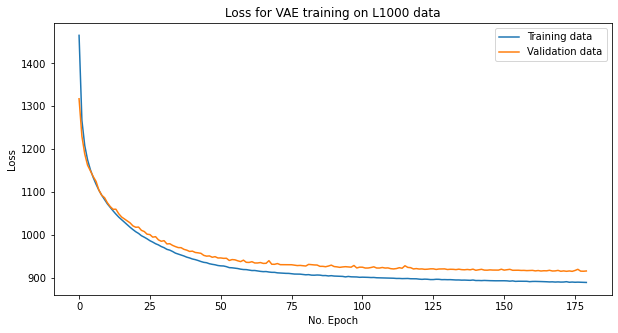

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
plt.ylabel("MSE + KL Divergence")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

369/369 [==============================] - 1s 2ms/step - loss: 908.8754 - recon: 826.6530 - kl: 82.2224


[908.8753662109375, 826.6529541015625, 82.22235107421875]

In [19]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

3123.429024640225

<AxesSubplot:>

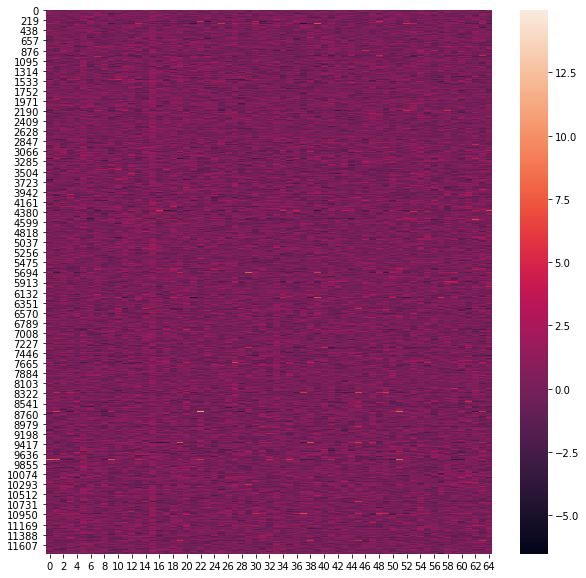

In [20]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:

reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)

pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


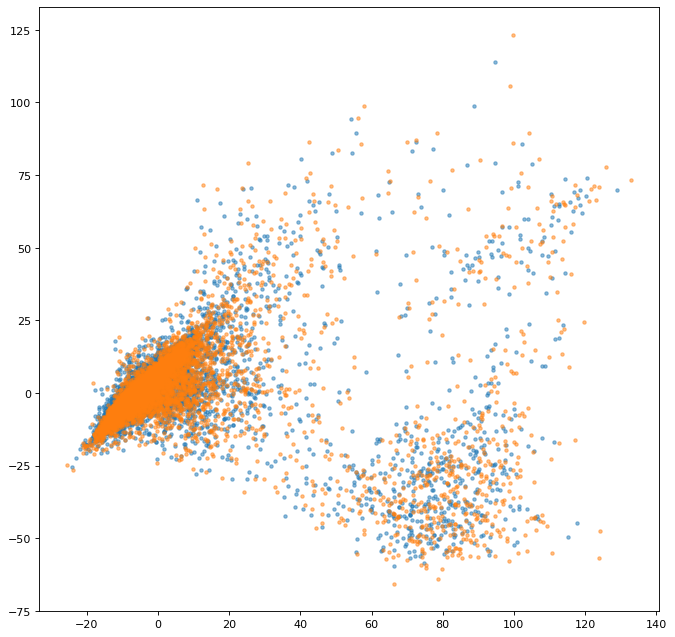

In [22]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)


In [23]:
import umap
reducer = umap.UMAP().fit(test_features_df)
original_test_embedding = reducer.transform(test_features_df)
reconstructed_test_embedding = reducer.transform(reconstruction)

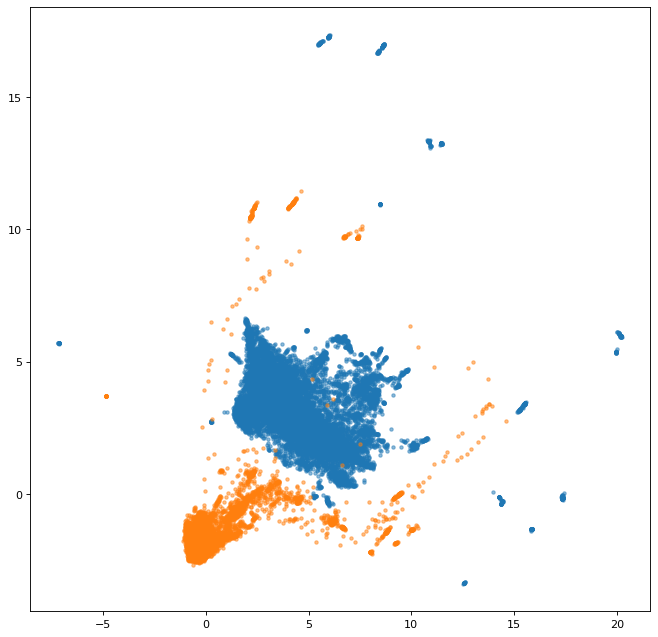

In [24]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(original_test_embedding[:,0],original_test_embedding[:,1], marker = ".", alpha = 0.5)
plt.scatter(reconstructed_test_embedding[:,0],reconstructed_test_embedding[:,1], marker = ".", alpha = 0.5)

In [25]:
decoder = L1000_vae.decoder_block["decoder"]


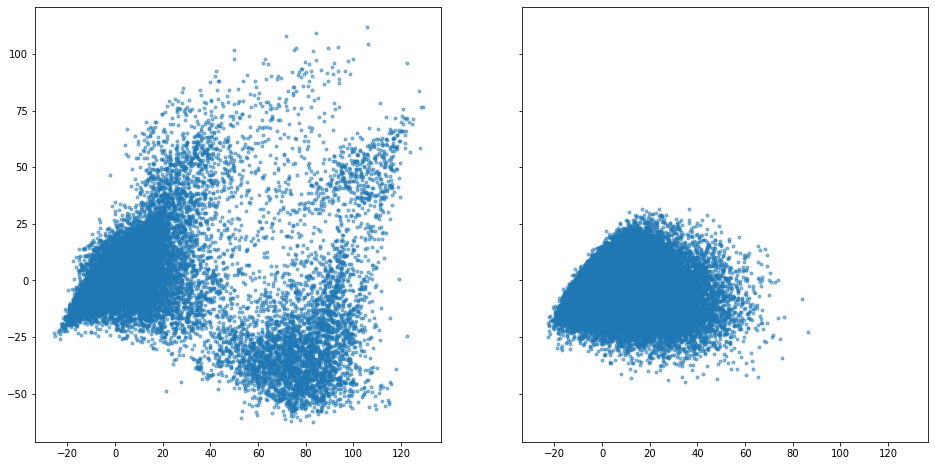

In [26]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(94440, 65)), columns=np.arange(0,65))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [27]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

200.1563908547071

In [28]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latentTwoLayer_vanilla.csv")

In [31]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save('./models/L1000twolayerDecoder_vanilla')

INFO:tensorflow:Assets written to: ./L1000twolayerDecoder_vanilla/assets


In [32]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
encoder.save('./models/L1000twolayerEncoder_vanilla')

INFO:tensorflow:Assets written to: ./L1000twolayerEncoder_vanilla/assets
